In [6]:
# -- driver_run_forecast_LV1.py  --
# master python script to do a full LV1 forecast simulation

import sys
import pickle
import matplotlib.pyplot as plt
import numpy as np
import os
from datetime import datetime, timezone
import gc
import resource
import xarray as xr
import netCDF4 as nc
import importlib

##############

sys.path.append('../sdpm_py_util')

import atm_functions as atmfuns
import ocn_functions as ocnfuns
import grid_functions as grdfuns
import util_functions as utlfuns 
import plotting_functions as pltfuns
from util_functions import s_coordinate_4
from get_PFM_info import get_PFM_info
from make_LV1_dotin_and_SLURM import make_LV1_dotin_and_SLURM
from run_slurm_LV1 import run_slurm_LV1


PFM=get_PFM_info()

run_type = 'forecast'
# we will use hycom for IC and BC
ocn_mod = PFM['ocn_model']
print('ocean boundary and initial conditions will be from:')
print(ocn_mod)
# we will use nam_nest for the atm forcing
atm_mod = PFM['atm_model']
print('atm forcing will be from:')
print(atm_mod)
# we will use opendap, and netcdf to grab ocn, and atm data
get_method = 'open_dap_nc'
# figure out what the time is local and UTC
start_time = datetime.now()
utc_time = datetime.now(timezone.utc)
year_utc = utc_time.year
month_utc = utc_time.month
day_utc = utc_time.day
hour_utc = utc_time.hour

print("Starting: driver_run_forecast_LV1: Current local Time =", start_time, "UTC = ",utc_time)

if hour_utc < 12:
    hour_utc=12
    day_utc=day_utc-1  # this only works if day_utc \neq 1

yyyymmdd = "%d%02d%02d" % (year_utc, month_utc, day_utc)
    
#yyyymmdd = '20240717'
# the hour in Z of the forecast, hycom has forecasts once per day starting at 1200Z
hhmm='1200'
forecastZdatestr = yyyymmdd+hhmm+'Z'   # this could be used for model output to indicate when model was initialized.

yyyymmdd = '20240803'
print("Preparing forecast starting on ",yyyymmdd)


# get the ROMS grid as a dict
RMG = grdfuns.roms_grid_to_dict(PFM['lv1_grid_file'])

get_PFM_info(): running onswell
ocean boundary and initial conditions will be from:
hycom
atm forcing will be from:
nam_nest
Starting: driver_run_forecast_LV1: Current local Time = 2024-08-07 14:45:06.977464 UTC =  2024-08-07 21:45:06.977481+00:00
Preparing forecast starting on  20240803


In [3]:
# Loading ATM
ATM = atmfuns.get_atm_data_as_dict(yyyymmdd,hhmm,run_type,atm_mod,get_method,PFM)

getting atm forecast for:
[datetime.datetime(2024, 8, 3, 12, 0) datetime.datetime(2024, 8, 3, 15, 0)
 datetime.datetime(2024, 8, 3, 18, 0) datetime.datetime(2024, 8, 3, 21, 0)
 datetime.datetime(2024, 8, 4, 0, 0) datetime.datetime(2024, 8, 4, 3, 0)
 datetime.datetime(2024, 8, 4, 6, 0) datetime.datetime(2024, 8, 4, 9, 0)
 datetime.datetime(2024, 8, 4, 12, 0) datetime.datetime(2024, 8, 4, 15, 0)
 datetime.datetime(2024, 8, 4, 18, 0) datetime.datetime(2024, 8, 4, 21, 0)
 datetime.datetime(2024, 8, 5, 0, 0) datetime.datetime(2024, 8, 5, 3, 0)
 datetime.datetime(2024, 8, 5, 6, 0) datetime.datetime(2024, 8, 5, 9, 0)
 datetime.datetime(2024, 8, 5, 12, 0) datetime.datetime(2024, 8, 5, 15, 0)
 datetime.datetime(2024, 8, 5, 18, 0) datetime.datetime(2024, 8, 5, 21, 0)
 datetime.datetime(2024, 8, 6, 0, 0)]


In [74]:
# added this as when we make changes to pltfuns, we need to either restart kernel or reload it here. 
importlib.reload(pltfuns)

<module 'plotting_functions' from '/home/a1jadhav/pfm_root/PFM/driver/../sdpm_py_util/plotting_functions.py'>

In [85]:
int(np.nanmax(ATM['Tair'][0,:,:]))

999900026055400882176

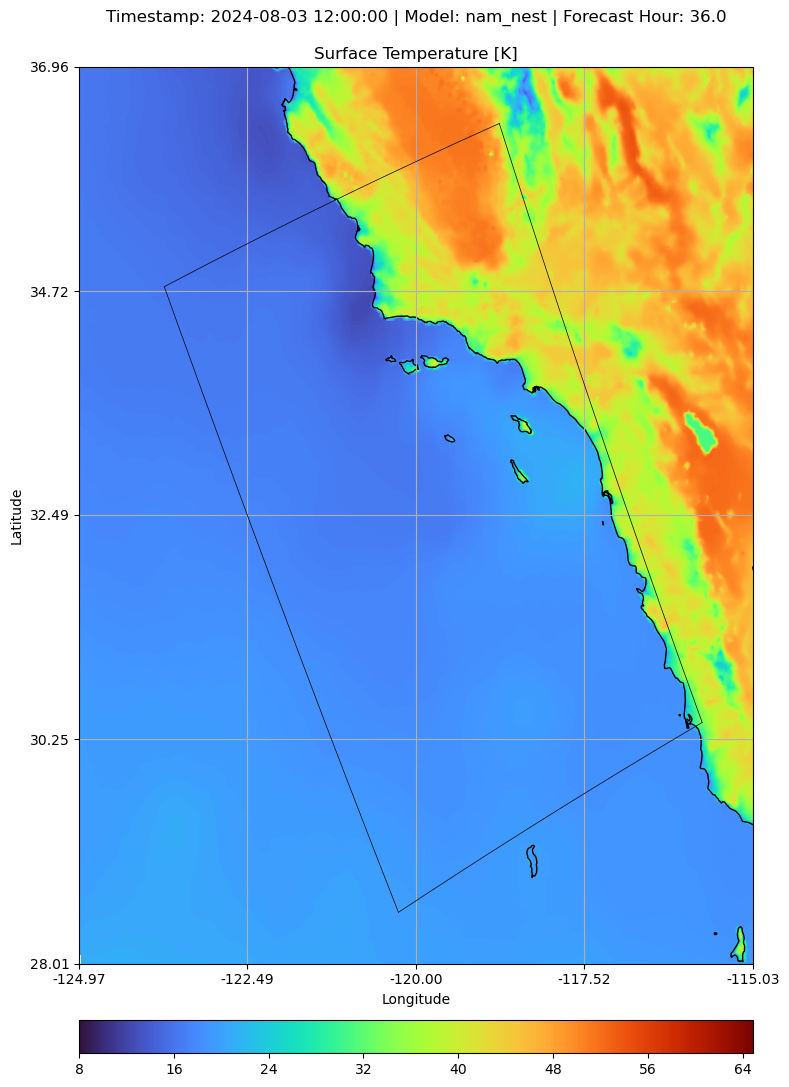

In [81]:
#plotting example for ATM
pltfuns.plot_atm_fields(ATM, RMG, PFM, fields_to_plot= 'temperature', show=True, forecast_hour=36)

In [14]:
ATM_R  = atmfuns.get_atm_data_on_roms_grid(ATM,RMG)

In [87]:
ATM_R['Qair'].min()

7.272407737223573

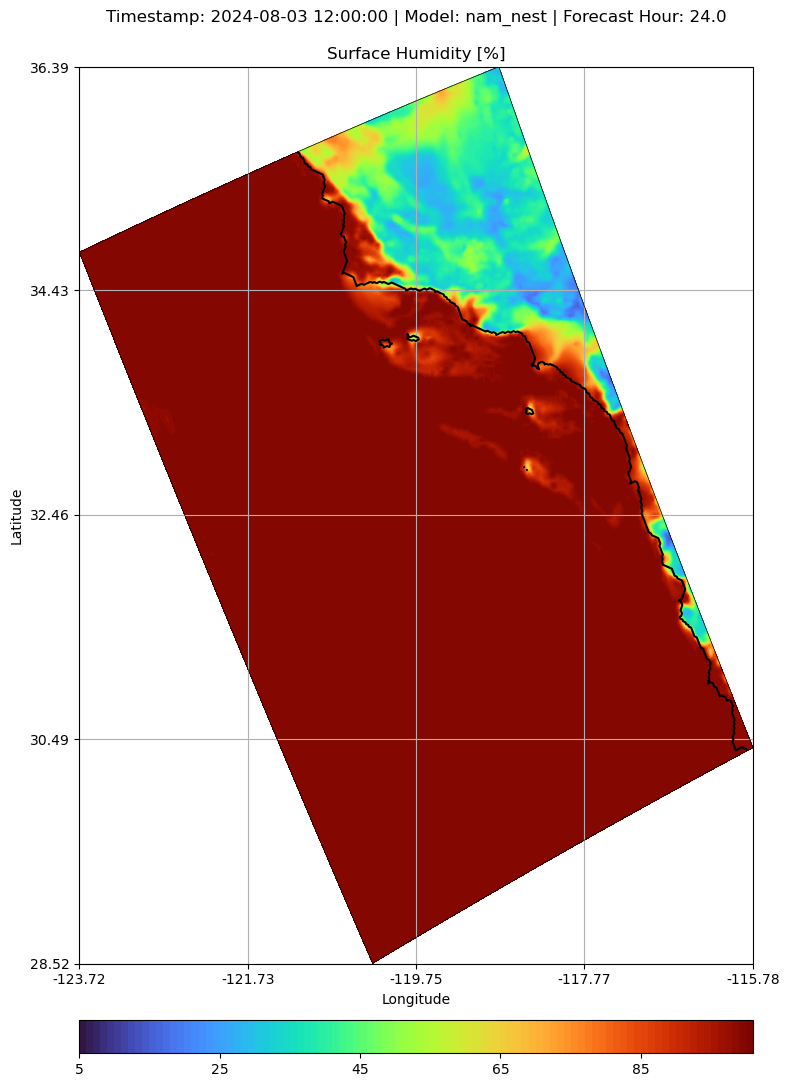

In [91]:
pltfuns.plot_atm_r_fields(ATM_R, RMG, PFM, show=True, fields_to_plot='humidity')

<Figure size 640x480 with 0 Axes>

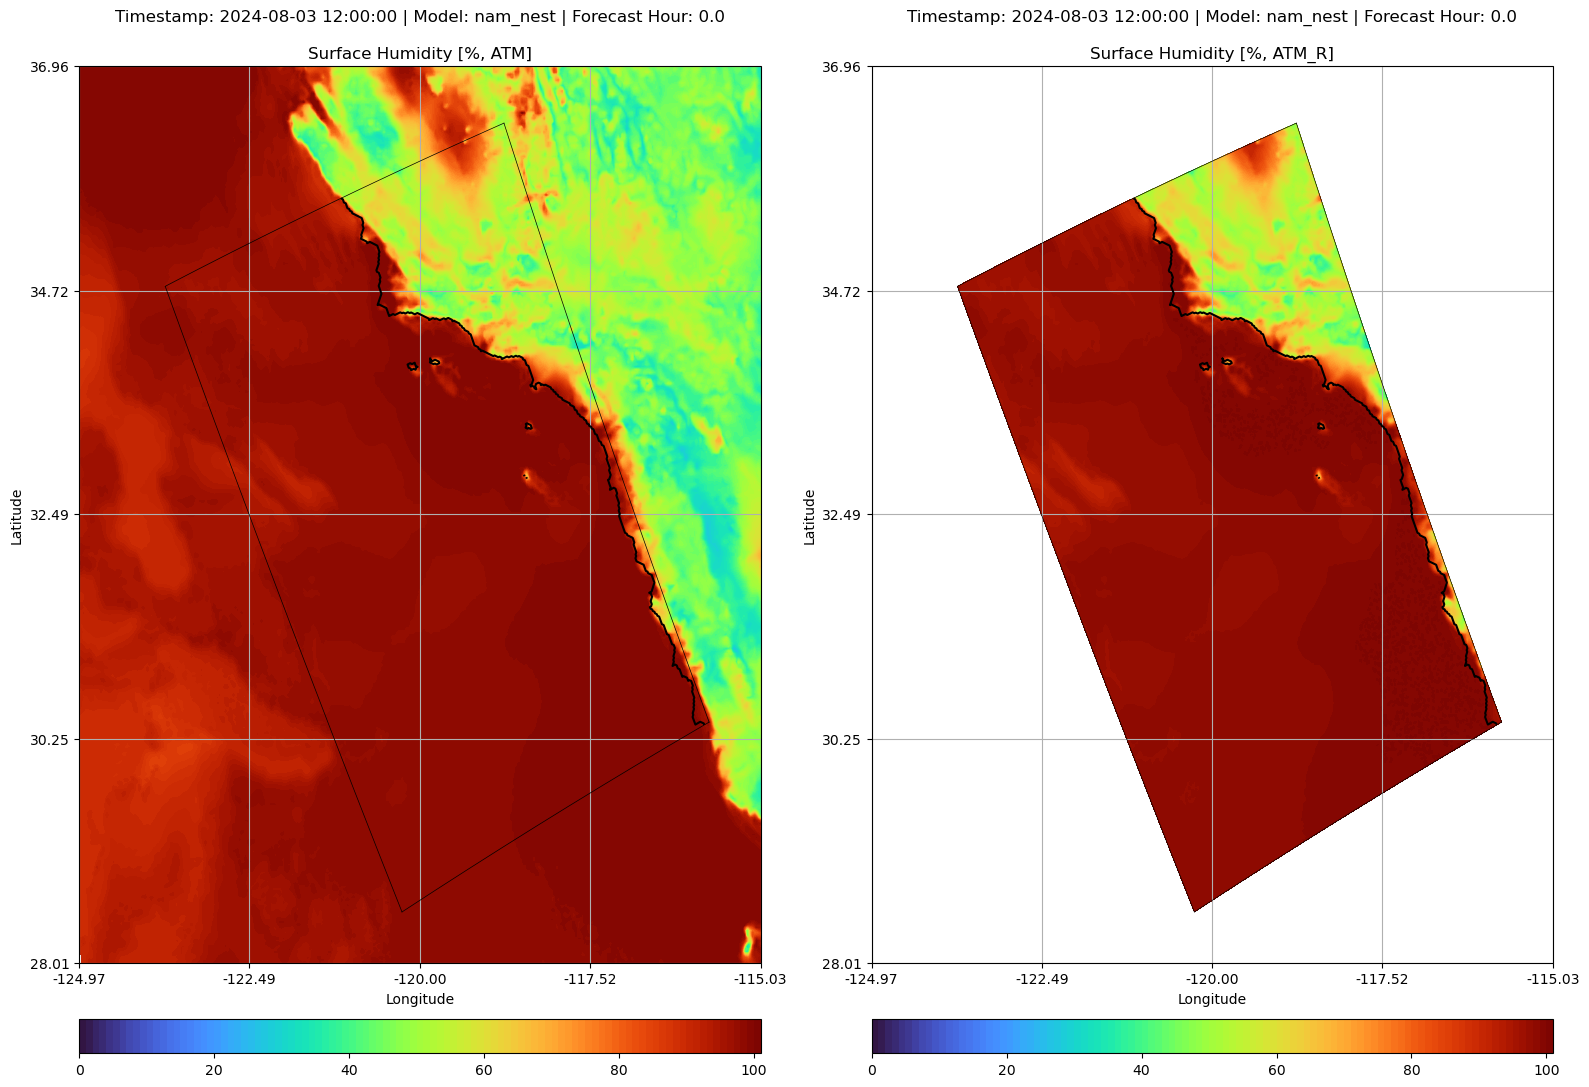

In [30]:
# plotting both ATM and ATM_R
pltfuns.plot_all_fields_in_one(ATM, ATM_R, RMG, PFM, show = True, fields_to_plot='humidity')

In [1]:
# -- driver_run_forecast_LV1.py  --
# master python script to do a full LV1 forecast simulation

import sys
import pickle
#import matplotlib.pyplot as plt
import numpy as np
import os
from datetime import datetime, timezone
import gc
import resource
import subprocess
#import xarray as xr
#import netCDF4 as nc

##############

sys.path.append('../sdpm_py_util')

import atm_functions as atmfuns
import ocn_functions as ocnfuns
import grid_functions as grdfuns
import util_functions as utlfuns 
import plotting_functions as pltfuns
from util_functions import s_coordinate_4
from get_PFM_info import get_PFM_info
from make_LV1_dotin_and_SLURM import make_LV1_dotin_and_SLURM
from run_slurm_LV1 import run_slurm_LV1


PFM=get_PFM_info()

run_type = 'forecast'
# we will use hycom for IC and BC
ocn_mod = PFM['ocn_model']
print('ocean boundary and initial conditions will be from:')
print(ocn_mod)
# we will use nam_nest for the atm forcing
atm_mod = PFM['atm_model']
print('atm forcing will be from:')
print(atm_mod)
# we will use opendap, and netcdf to grab ocn, and atm data
get_method = 'open_dap_nc'
# figure out what the time is local and UTC
start_time = datetime.now()
utc_time = datetime.now(timezone.utc)
year_utc = utc_time.year
month_utc = utc_time.month
day_utc = utc_time.day
hour_utc = utc_time.hour

print("Starting: driver_run_forecast_LV1: Current local Time =", start_time, "UTC = ",utc_time)

if hour_utc < 12:
    hour_utc=12
    day_utc=day_utc-1  # this only works if day_utc \neq 1

yyyymmdd = "%d%02d%02d" % (year_utc, month_utc, day_utc)
    
#yyyymmdd = '20240717'
# the hour in Z of the forecast, hycom has forecasts once per day starting at 1200Z
hhmm='1200'
forecastZdatestr = yyyymmdd+hhmm+'Z'   # this could be used for model output to indicate when model was initialized.

yyyymmdd = '20240803'
print("Preparing forecast starting on ",yyyymmdd)


# get the ROMS grid as a dict
RMG = grdfuns.roms_grid_to_dict(PFM['lv1_grid_file'])

get_PFM_info(): running onswell
ocean boundary and initial conditions will be from:
hycom
atm forcing will be from:
nam_nest
Starting: driver_run_forecast_LV1: Current local Time = 2024-08-07 14:40:06.148340 UTC =  2024-08-07 21:40:06.148364+00:00
Preparing forecast starting on  20240803


/home/a1jadhav/pfm_root/PFM/driver/../sdpm_py_util/ocn_functions.py:25: UserWarning: The seawater library is deprecated! Please use gsw instead.
  import seawater


In [2]:
OCN_R = ocnfuns.load_ocnR_from_pckl_files()
print(OCN_R.keys())

get_PFM_info(): running onswell
dict_keys(['depth', 'lat_rho', 'lon_rho', 'lat_u', 'lon_u', 'lat_v', 'lon_v', 'ocean_time', 'ocean_time_ref', 'salt', 'temp', 'ubar', 'urm', 'vbar', 'vrm', 'zeta', 'vinfo'])


In [9]:

file_path = "/scratch/PFM_Simulations/LV1_Forecast/Forc/LV1_OCEAN_IC.nc"

ds = nc.Dataset(file_path)
ds

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    type: ocean initial condition file fields for starting roms
    time info: ocean time is from 1999/01/01 00:00:00
    coordinates: lat_u lon_u ocean_time lat_v Cs_r lon_rho lon_v lat_rho
    dimensions(sizes): time(1), s_rho(40), er(390), xr(253), eu(390), xu(252), ev(389), xv(253)
    variables(dimensions): float64 temp(time, s_rho, er, xr), float64 salt(time, s_rho, er, xr), float64 u(time, s_rho, eu, xu), float64 v(time, s_rho, ev, xv), float64 ubar(time, eu, xu), float64 vbar(time, ev, xv), float64 zeta(time, er, xr), int64 Vtransform(), int64 Vstretching(), float64 theta_s(), float64 theta_b(), float64 Tcline(), float64 hc(), float64 lat_rho(er, xr), float64 lon_rho(er, xr), float64 lat_u(eu, xu), float64 lon_u(eu, xu), float64 lat_v(ev, xv), float64 lon_v(ev, xv), float64 ocean_time(time), float64 Cs_r(s_rho)
    groups: 

In [49]:
import xarray as xr
xr2 = xr.open_dataset(file_path)

In [50]:
xr2

<xarray.Dataset>
Dimensions:      (time: 1, s_rho: 40, er: 390, xr: 253, eu: 390, xu: 252,
                  ev: 389, xv: 253)
Coordinates:
    lat_rho      (er, xr) float64 ...
    lon_rho      (er, xr) float64 ...
    lat_u        (eu, xu) float64 ...
    lon_u        (eu, xu) float64 ...
    lat_v        (ev, xv) float64 ...
    lon_v        (ev, xv) float64 ...
    ocean_time   (time) timedelta64[ns] ...
    Cs_r         (s_rho) float64 ...
Dimensions without coordinates: time, s_rho, er, xr, eu, xu, ev, xv
Data variables: (12/13)
    temp         (time, s_rho, er, xr) float64 ...
    salt         (time, s_rho, er, xr) float64 ...
    u            (time, s_rho, eu, xu) float64 ...
    v            (time, s_rho, ev, xv) float64 ...
    ubar         (time, eu, xu) float64 ...
    vbar         (time, ev, xv) float64 ...
    ...           ...
    Vtransform   int64 ...
    Vstretching  int64 ...
    theta_s      float64 ...
    theta_b      float64 ...
    Tcline       float64 ...
    hc           float64 ...
Attributes:
    type:       ocean initial condition file fields for starting roms
    time info:  ocean time is from 1999/01/01 00:00:00

/home/a1jadhav/anaconda3/lib/python3.12/site-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/10m_physical/ne_10m_ocean.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/home/a1jadhav/anaconda3/lib/python3.12/site-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/10m_physical/ne_10m_lakes.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/home/a1jadhav/anaconda3/lib/python3.12/site-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/10m_physical/ne_10m_rivers_lake_centerlines.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


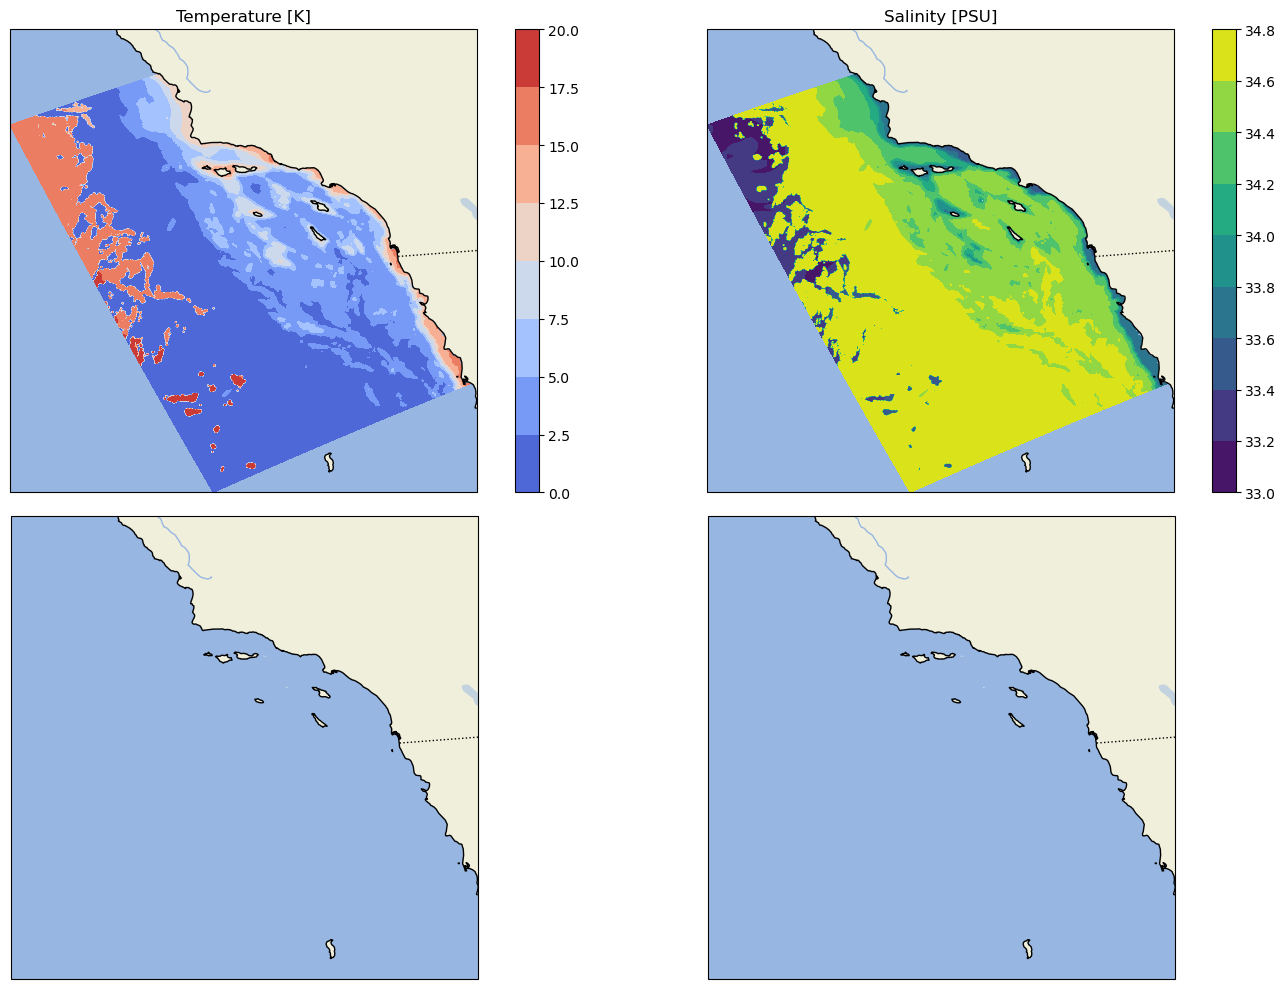

In [11]:
import matplotlib.pyplot as plt
from netCDF4 import Dataset
import numpy as np
import cartopy.crs as ccrs
import cartopy.feature as cfeature

def plot_ocn_ic(ncfile, depth_index=0):
    # Open the netCDF file
    nc = Dataset(ncfile, 'r')

    # Extract variables
    lon = nc.variables['lon_rho'][:]
    lat = nc.variables['lat_rho'][:]
    temp = nc.variables['temp'][0, depth_index, :, :]
    salt = nc.variables['salt'][0, depth_index, :, :]
    u = nc.variables['u'][0, depth_index, :, :]
    v = nc.variables['v'][0, depth_index, :, :]
    zeta = nc.variables['zeta'][0, :, :]
    
    # Close the netCDF file
    nc.close()

    # Create figure and axes
    fig, axs = plt.subplots(2, 2, figsize=(15, 10), subplot_kw={'projection': ccrs.PlateCarree()})

    # Plot temperature
    c1 = axs[0, 0].contourf(lon, lat, temp, cmap='coolwarm', transform=ccrs.PlateCarree())
    axs[0, 0].set_title('Temperature [K]')
    fig.colorbar(c1, ax=axs[0, 0])

    # Plot salinity
    c2 = axs[0, 1].contourf(lon, lat, salt, cmap='viridis', transform=ccrs.PlateCarree())
    axs[0, 1].set_title('Salinity [PSU]')
    fig.colorbar(c2, ax=axs[0, 1])

    # # Plot u velocity
    # c3 = axs[1, 0].contourf(lon, lat, u, cmap='plasma', transform=ccrs.PlateCarree())
    # axs[1, 0].set_title('U Velocity [m/s]')
    # fig.colorbar(c3, ax=axs[1, 0])

    # # Plot v velocity
    # c4 = axs[1, 1].contourf(lon, lat, v, cmap='plasma', transform=ccrs.PlateCarree())
    # axs[1, 1].set_title('V Velocity [m/s]')
    # fig.colorbar(c4, ax=axs[1, 1])

    # Add coastline to all plots
    for ax in axs.flat:
        ax.add_feature(cfeature.COASTLINE)
        ax.add_feature(cfeature.BORDERS, linestyle=':')
        ax.add_feature(cfeature.LAND)
        ax.add_feature(cfeature.OCEAN)
        ax.add_feature(cfeature.LAKES, alpha=0.5)
        ax.add_feature(cfeature.RIVERS)
        ax.set_extent([lon.min(), lon.max(), lat.min(), lat.max()], crs=ccrs.PlateCarree())

    plt.tight_layout()
    plt.show()

# Example usage
plot_ocn_ic("/scratch/PFM_Simulations/LV1_Forecast/Forc/LV1_OCEAN_IC.nc", depth_index=0)  # Change depth_index as needed

In [43]:
from netCDF4 import num2date
from scipy.interpolate import griddata

def plot_ocn_ic_fields(ocn_ic_file, RMG, fields_to_plot=None, time_index=0, depth_index=0, show=False):
    # Open the netCDF file
    nc = Dataset(ocn_ic_file, 'r')

    # Extract coordinate variables
    lon_rho = nc.variables['lon_rho'][:]
    lat_rho = nc.variables['lat_rho'][:]
    time = nc.variables['ocean_time'][time_index]
    start_time = num2date(time, units='days since 1999-01-01')  # Adjust units as needed

    if fields_to_plot is None:
        fields_to_plot = ['velocity', 'zeta', 'temp', 'salt']
    else:
        fields_to_plot = [fields_to_plot] if isinstance(fields_to_plot, str) else fields_to_plot

    for field in fields_to_plot:
        fig, ax = plt.subplots(figsize=(8, 12), subplot_kw={'projection': ccrs.PlateCarree()})
        cmap = plt.get_cmap('turbo')
        plt.set_cmap(cmap)

        if field == 'velocity':
            u = nc.variables['u'][time_index, depth_index, :, :]  # Adjust the depth index as needed
            v = nc.variables['v'][time_index, depth_index, :, :]  # Adjust the depth index as needed

            # Coordinates for u and v
            lon_u = nc.variables['lon_u'][:]
            lat_u = nc.variables['lat_u'][:]
            lon_v = nc.variables['lon_v'][:]
            lat_v = nc.variables['lat_v'][:]

            # Interpolate u and v to rho points
            u_interp = griddata((lon_u.flatten(), lat_u.flatten()), u.flatten(), (lon_rho, lat_rho), method='linear')
            v_interp = griddata((lon_v.flatten(), lat_v.flatten()), v.flatten(), (lon_rho, lat_rho), method='linear')

            magnitude = np.sqrt(u_interp**2 + v_interp**2)
            plevs = np.linspace(np.nanmin(magnitude), np.nanmax(magnitude), 50)
            cset = ax.contourf(lon_rho, lat_rho, magnitude, plevs, cmap=cmap, transform=ccrs.PlateCarree())
            # ax.quiver(lon_rho[::5], lat_rho[::5], u[::5, ::5], v[::5, ::5], transform=ccrs.PlateCarree())
            cbar = fig.colorbar(cset, ax=ax, orientation='horizontal', pad=0.05)
            cbar.set_label('Velocity Magnitude [m/s]')
            cbar.set_ticks(np.linspace(np.nanmin(magnitude), np.nanmax(magnitude), 5))
            ax.set_title('Surface Velocity [m/s]')
        
        elif field == 'zeta':
            zeta = nc.variables['zeta'][time_index, :, :]
            plevs = np.linspace(np.nanmin(zeta), np.nanmax(zeta), 50)
            cset = ax.contourf(lon_rho, lat_rho, zeta, plevs, cmap=cmap, transform=ccrs.PlateCarree())
            cbar = fig.colorbar(cset, ax=ax, orientation='horizontal', pad=0.05)
            cbar.set_label('Surface Elevation [m]')
            cbar.set_ticks(np.linspace(np.nanmin(zeta), np.nanmax(zeta), 5))
            ax.set_title('Surface Elevation [m]')
        
        elif field == 'temp':
            temp = nc.variables['temp'][time_index, depth_index, :, :]
            plevs = np.linspace(np.nanmin(temp), np.nanmax(temp), 50)
            cset = ax.contourf(lon_rho, lat_rho, temp, plevs, cmap=cmap, transform=ccrs.PlateCarree())
            cbar = fig.colorbar(cset, ax=ax, orientation='horizontal', pad=0.05)
            cbar.set_label('Surface Temperature [K]')
            cbar.set_ticks(np.linspace(np.nanmin(temp), np.nanmax(temp), 5))
            ax.set_title('Surface Temperature [K]')
        
        elif field == 'salt':
            salt = nc.variables['salt'][time_index, depth_index, :, :]
            plevs = np.linspace(np.nanmin(salt), np.nanmax(salt), 50)
            cset = ax.contourf(lon_rho, lat_rho, salt, plevs, cmap=cmap, transform=ccrs.PlateCarree())
            cbar = fig.colorbar(cset, ax=ax, orientation='horizontal', pad=0.05)
            cbar.set_ticks(np.linspace(np.nanmin(salt), np.nanmax(salt), 5))
            cbar.set_label('Salinity [psu]')
            ax.set_title('Surface Salinity [psu]')
        
        # Add coastlines and gridlines
        ax.set_xlabel('Longitude')
        ax.set_ylabel('Latitude')
        ax.add_feature(cfeature.LAND, zorder=1, edgecolor='black')
        ax.grid(True)
        
        # Plot ROMS box if required, this is a placeholder function call
        pltfuns.plot_roms_box(ax, RMG)  # Define this function if you need to plot a ROMS grid box
        
        ax.set_aspect('auto')
        ax.set_xticks(np.round(np.linspace(np.min(lon_rho), np.max(lon_rho), num=5), 2))
        ax.set_yticks(np.round(np.linspace(np.min(lat_rho), np.max(lat_rho), num=5), 2))
        ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.2f}'))
        ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y:.2f}'))
        
        # Set the title and labels
        annotation = f'Timestamp: {start_time.strftime("%Y-%m-%d %H:%M:%S")} | Model: ROMS | Forecast Hour: {time_index}'
        ax.text(0.5, 1.05, annotation, transform=ax.transAxes, ha='center', fontsize=12)
        
        
        if show:
            plt.show()
        else:
            plt.close()

    # Close the netCDF file
    nc.close()

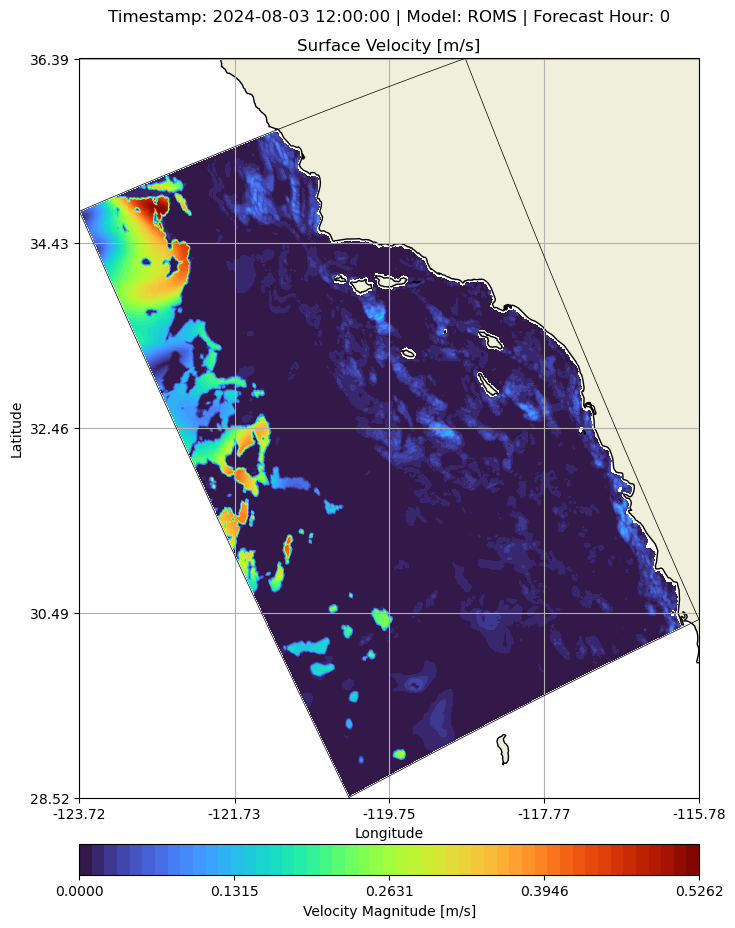

In [44]:
plot_ocn_ic_fields(file_path, RMG, fields_to_plot='velocity', show=True)

In [35]:
u_rho = 0.5 * (ds['u'][:, :-1] + ds['u'][:, 1:])
v_rho = 0.5 * (ds['v'][:-1, :] + ds['v'][1:, :])
np.shape(v_rho)

(0, 40, 389, 253)

In [37]:
np.shape(ds['v'])

(1, 40, 389, 253)

In [45]:
file_path1 = "/scratch/PFM_Simulations/LV1_Forecast/Forc/LV1_OCEAN_BC.nc"

In [53]:
xr1 = xr.open_dataset(file_path1)
xr1

<xarray.Dataset>
Dimensions:      (time: 21, s_rho: 40, xr: 253, xu: 252, xv: 253, er: 390,
                  eu: 390, ev: 389)
Coordinates:
    ocean_time   (time) timedelta64[ns] ...
    Cs_r         (s_rho) float64 ...
Dimensions without coordinates: time, s_rho, xr, xu, xv, er, eu, ev
Data variables: (12/27)
    temp_south   (time, s_rho, xr) float64 ...
    salt_south   (time, s_rho, xr) float64 ...
    u_south      (time, s_rho, xu) float64 ...
    v_south      (time, s_rho, xv) float64 ...
    ubar_south   (time, xu) float64 ...
    vbar_south   (time, xv) float64 ...
    ...           ...
    Vtransform   int64 ...
    Vstretching  int64 ...
    theta_s      float64 ...
    theta_b      float64 ...
    Tcline       float64 ...
    hc           float64 ...
Attributes:
    type:       ocean boundary condition file fields for starting roms
    time info:  ocean time is from 1999/01/01 00:00:00

In [55]:
ds1 = nc.Dataset(file_path1)

In [56]:
ds1

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    type: ocean boundary condition file fields for starting roms
    time info: ocean time is from 1999/01/01 00:00:00
    coordinates: ocean_time Cs_r
    dimensions(sizes): time(21), s_rho(40), xr(253), xu(252), xv(253), er(390), eu(390), ev(389)
    variables(dimensions): float64 temp_south(time, s_rho, xr), float64 salt_south(time, s_rho, xr), float64 u_south(time, s_rho, xu), float64 v_south(time, s_rho, xv), float64 ubar_south(time, xu), float64 vbar_south(time, xv), float64 zeta_south(time, xr), float64 temp_north(time, s_rho, xr), float64 salt_north(time, s_rho, xr), float64 u_north(time, s_rho, xu), float64 v_north(time, s_rho, xv), float64 ubar_north(time, xu), float64 vbar_north(time, xv), float64 zeta_north(time, xr), float64 temp_west(time, s_rho, er), float64 salt_west(time, s_rho, er), float64 u_west(time, s_rho, eu), float64 v_west(time, s_rho, ev), float64 ubar_west(time, eu), float64

In [60]:
import matplotlib.pyplot as plt
from netCDF4 import Dataset, num2date
import numpy as np

def plot_bc_fields(bc_file, RMG, fields_to_plot=None, time_index=0, show=False):
    # Open the netCDF file
    nc = Dataset(bc_file, 'r')

    # Extract coordinate variables
    lon_rho = RMG['lon_rho'][-1, :]  # Northern edge longitude
    lat_rho = RMG['lat_rho'][-1, :]  # Northern edge latitude
    depth = np.arange(nc.dimensions['s_rho'].size)  # Depth levels (assuming evenly spaced)
    time = nc.variables['ocean_time'][time_index]

    # Debug: print the units of ocean_time
    print("ocean_time units:", nc.variables['ocean_time'].units)

    # Adjust units string as needed
    units = nc.variables['ocean_time'].units
    if units.startswith('days'):
        units = 'days since 1999-01-01 00:00:00'  # Adjust to the correct format if needed

    start_time = num2date(time, units=units)

    if fields_to_plot is None:
        fields_to_plot = ['zeta', 'temp', 'salt']
    else:
        fields_to_plot = [fields_to_plot] if isinstance(fields_to_plot, str) else fields_to_plot

    for field in fields_to_plot:
        fig, ax = plt.subplots(figsize=(10, 8))
        cmap = plt.get_cmap('turbo')
        plt.set_cmap(cmap)

        if field == 'zeta':
            zeta = nc.variables['zeta_north'][time_index, :]
            lon_mesh, depth_mesh = np.meshgrid(lon_rho, depth)
            zeta_2d = np.tile(zeta, (depth.size, 1))

            plevs = np.linspace(np.nanmin(zeta_2d), np.nanmax(zeta_2d), 50)
            cset = ax.contourf(lon_mesh, depth_mesh, zeta_2d, plevs, cmap=cmap)
            cbar = fig.colorbar(cset, ax=ax, orientation='horizontal', pad=0.05)
            cbar.set_label('Surface Elevation [m]')
            cbar.set_ticks(np.linspace(np.nanmin(zeta_2d), np.nanmax(zeta_2d), 5))
            ax.set_title('Northern Boundary Surface Elevation [m]')
        
        elif field == 'temp':
            temp = nc.variables['temp_north'][time_index, :, :]
            lon_mesh, depth_mesh = np.meshgrid(lon_rho, depth)

            plevs = np.linspace(np.nanmin(temp), np.nanmax(temp), 50)
            cset = ax.contourf(lon_mesh, depth_mesh, temp, plevs, cmap=cmap)
            cbar = fig.colorbar(cset, ax=ax, orientation='horizontal', pad=0.05)
            cbar.set_label('Temperature [K]')
            cbar.set_ticks(np.linspace(np.nanmin(temp), np.nanmax(temp), 5))
            ax.set_title('Northern Boundary Temperature [K]')
        
        elif field == 'salt':
            salt = nc.variables['salt_north'][time_index, :, :]
            lon_mesh, depth_mesh = np.meshgrid(lon_rho, depth)

            plevs = np.linspace(np.nanmin(salt), np.nanmax(salt), 50)
            cset = ax.contourf(lon_mesh, depth_mesh, salt, plevs, cmap=cmap)
            cbar = fig.colorbar(cset, ax=ax, orientation='horizontal', pad=0.05)
            cbar.set_ticks(np.linspace(np.nanmin(salt), np.nanmax(salt), 5))
            cbar.set_label('Salinity [psu]')
            ax.set_title('Northern Boundary Salinity [psu]')
        
        # Add labels
        ax.set_xlabel('Longitude')
        ax.set_ylabel('Depth Level')
        ax.invert_yaxis()  # Invert the y-axis to have depth increasing downwards

        # Set the title and labels
        annotation = f'Timestamp: {start_time.strftime("%Y-%m-%d %H:%M:%S")} | Model: ROMS | Boundary Condition'
        ax.text(0.5, 1.05, annotation, transform=ax.transAxes, ha='center', fontsize=12)
        
        if show:
            plt.show()
        else:
            plt.close()

    # Close the netCDF file
    nc.close()




ocean_time units: days


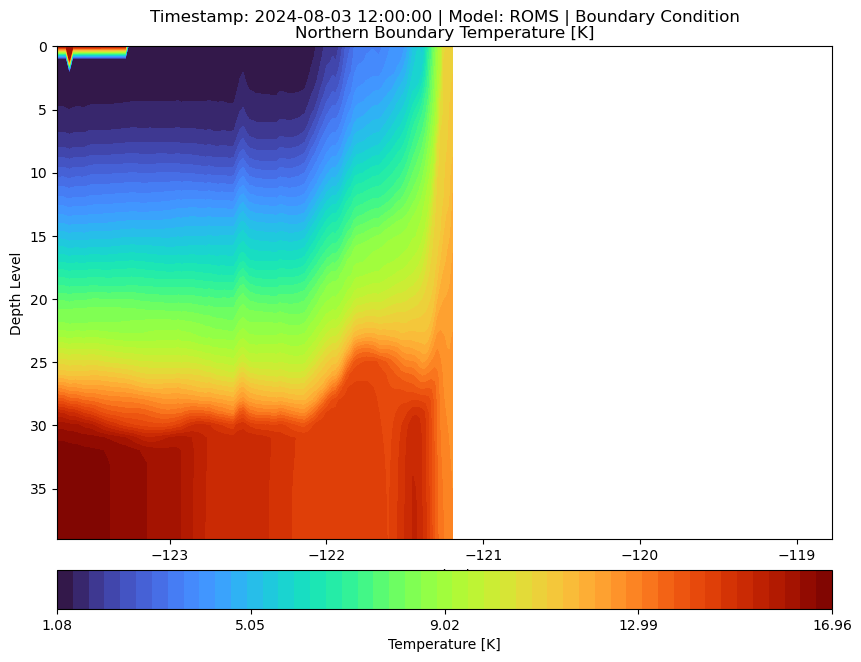

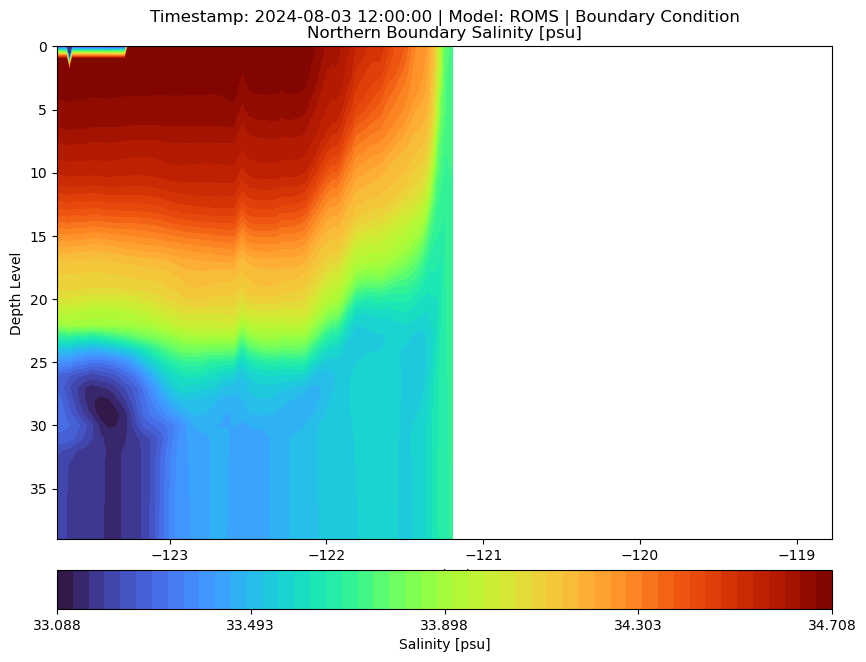

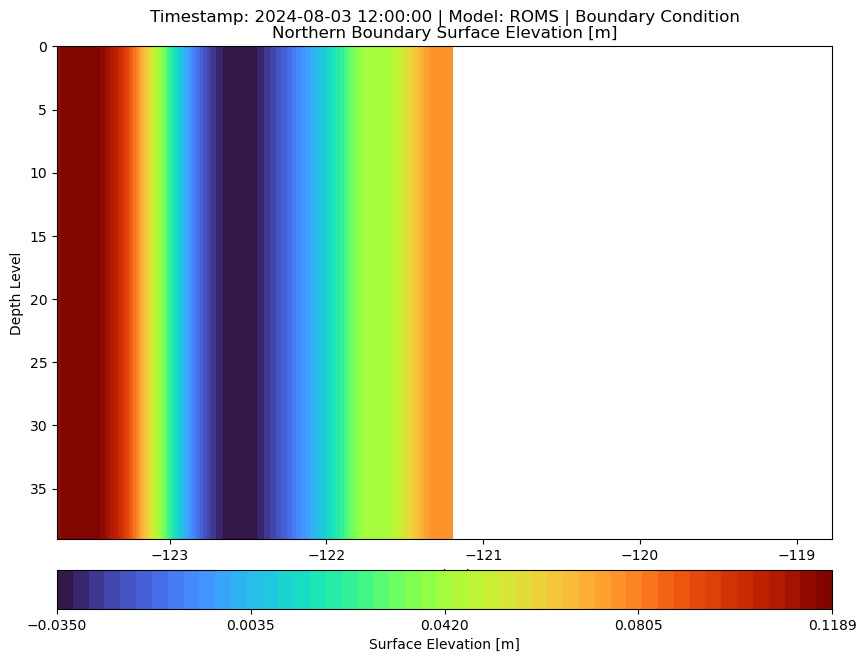

In [61]:
# Example usage
plot_bc_fields(file_path1, RMG, fields_to_plot=['temp', 'salt', 'zeta'], time_index=0, show=True)

In [70]:
def plot_bc_north(nc_file):
    # Open the netCDF file
    ds = Dataset(nc_file)
    
    # Extract the variables of interest
    ocean_time = ds.variables['ocean_time'][:]
    Cs_r = ds.variables['Cs_r'][:]
    temp_north = ds.variables['temp_north'][:]
    salt_north = ds.variables['salt_north'][:]
    # u_north = ds.variables['u_north'][:]
    # v_north = ds.variables['v_north'][:]
    ubar_north = ds.variables['ubar_north'][:]
    zeta_north = ds.variables['zeta_north'][:]
    
    # # Calculate the magnitude of the velocity
    # vel_north = np.sqrt(u_north**2 + v_north**2)
    
    # Create the figure and subplots
    fig, axs = plt.subplots(3, 2, figsize=(15, 15))
    axs = axs.flatten()
    
    # Plot temperature
    c1 = axs[0].contourf(ocean_time, Cs_r, temp_north[:, :, 0].T, cmap='coolwarm')
    fig.colorbar(c1, ax=axs[0])
    axs[0].set_title('Temperature North')
    axs[0].set_xlabel('Time')
    axs[0].set_ylabel('Cs_r')
    
    # Plot salinity
    c2 = axs[1].contourf(ocean_time, Cs_r, salt_north[:, :, 0].T, cmap='viridis')
    fig.colorbar(c2, ax=axs[1])
    axs[1].set_title('Salinity North')
    axs[1].set_xlabel('Time')
    axs[1].set_ylabel('Cs_r')
    
    # # Plot u velocity
    # c3 = axs[2].contourf(ocean_time, Cs_r, u_north[:, :, 0].T, cmap='plasma')
    # fig.colorbar(c3, ax=axs[2])
    # axs[2].set_title('U Velocity North')
    # axs[2].set_xlabel('Time')
    # axs[2].set_ylabel('Cs_r')
    
    # # Plot v velocity
    # c4 = axs[3].contourf(ocean_time, Cs_r, v_north[:, :, 0].T, cmap='inferno')
    # fig.colorbar(c4, ax=axs[3])
    # axs[3].set_title('V Velocity North')
    # axs[3].set_xlabel('Time')
    # axs[3].set_ylabel('Cs_r')
    
    # # Plot combined velocity magnitude
    # c5 = axs[4].contourf(ocean_time, Cs_r, vel_north[:, :, 0].T, cmap='cividis')
    # fig.colorbar(c5, ax=axs[4])
    # axs[4].set_title('Velocity Magnitude North')
    # axs[4].set_xlabel('Time')
    # axs[4].set_ylabel('Cs_r')
    
    # Plot zeta
    c6 = axs[5].contourf(ocean_time, zeta_north.T, cmap='magma')
    fig.colorbar(c6, ax=axs[5])
    axs[5].set_title('Zeta North')
    axs[5].set_xlabel('Time')
    axs[5].set_ylabel('Xr')
    
    plt.tight_layout()
    plt.show()

TypeError: Input z must be 2D, not 1D

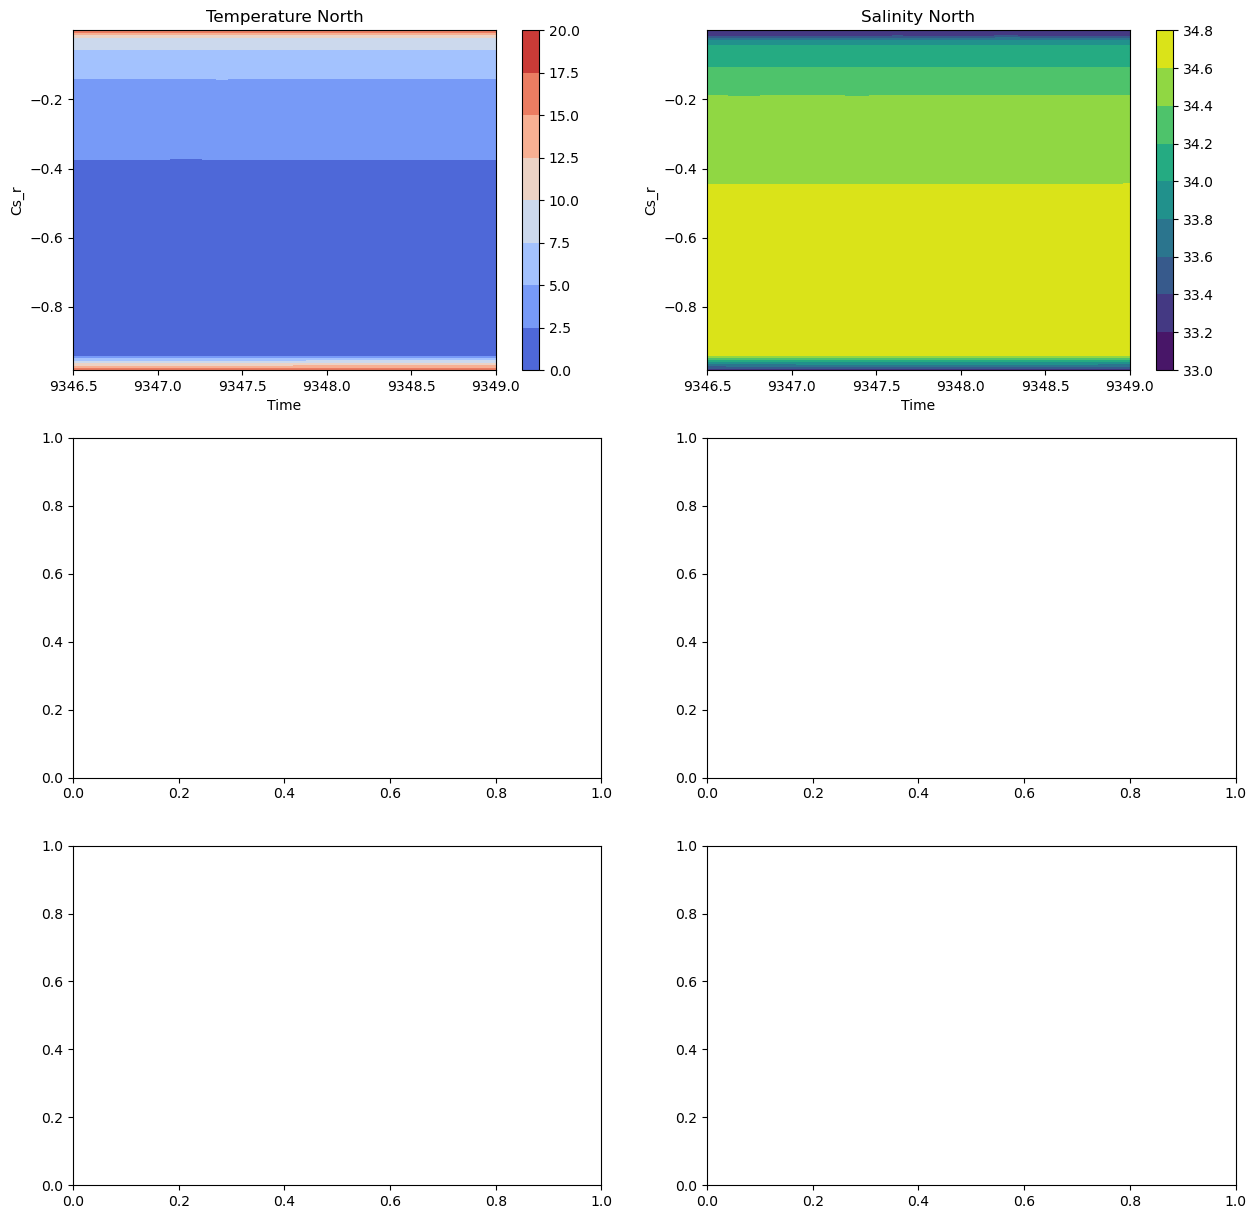

In [71]:
plot_bc_north(file_path1)

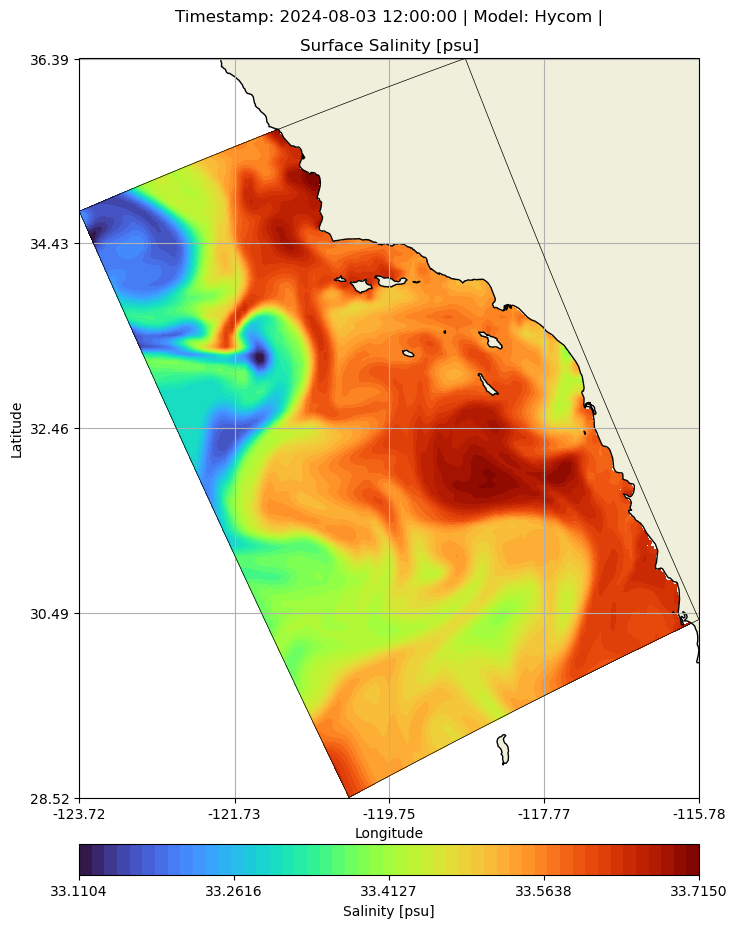

In [77]:
pltfuns.plot_ocn_R_fields(OCN_R, RMG, PFM, fields_to_plot='salt', show=True)

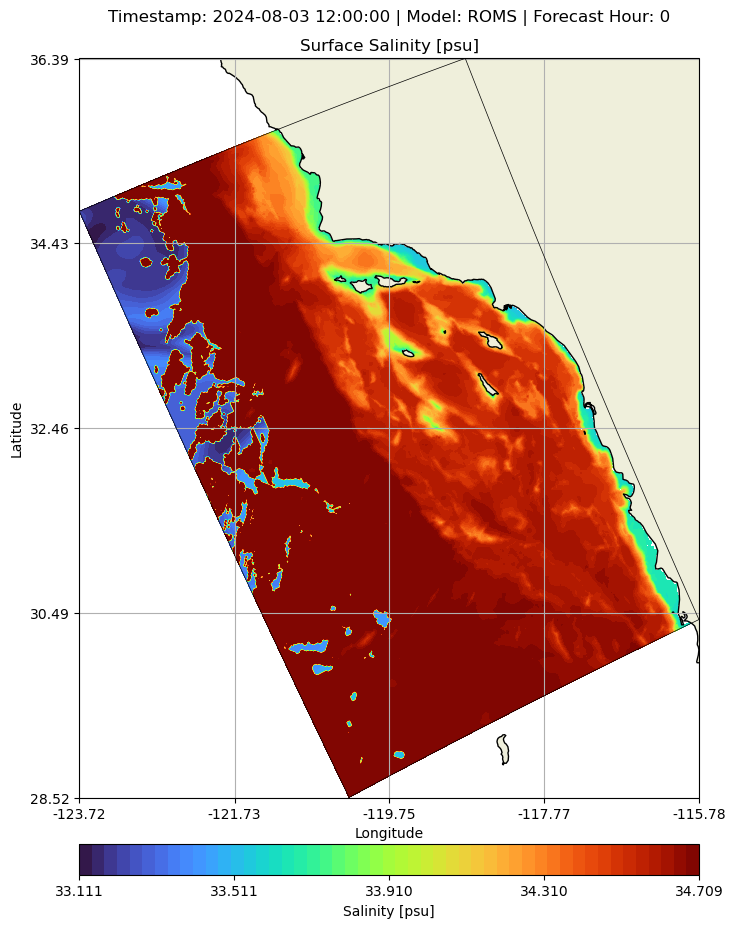

In [75]:
pltfuns.plot_ocn_ic_fields(file_path, RMG, PFM, fields_to_plot='salt', show=True)

In [78]:
file_path

'/scratch/PFM_Simulations/LV1_Forecast/Forc/LV1_OCEAN_IC.nc'